In [2]:
import numpy
print(numpy.__version__)

2.2.5


In [3]:

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
import seaborn as sns
import matplotlib as plt

In [4]:
file_path = 'sudoku.csv'
data = pd.read_csv(file_path)

In [5]:
data.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [6]:
data.shape

(1000000, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   quizzes    1000000 non-null  object
 1   solutions  1000000 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


In [8]:
data.describe()

,quizzes,solutions
count,1000000,1000000
unique,1000000,1000000
top,3000001070908026405807102007004000600296500080...,3629451871978326455847162937184235694296573186...
freq,1,1


In [9]:
data.isnull().values.any()

np.False_

In [10]:
duplicate_count = data.duplicated(subset=['quizzes', 'solutions']).sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


In [11]:
type(data['quizzes'][0])

str

In [12]:
len(data['quizzes'][0])

81

In [13]:
type(data['solutions'][0])

str

In [14]:
len(data['quizzes'][0])

81

In [15]:
print("Quiz:\n" , np.array(list(map(int,list(data["quizzes"][0])))).reshape(9,9))

Quiz:
 [[0 0 4 3 0 0 2 0 9]
 [0 0 5 0 0 9 0 0 1]
 [0 7 0 0 6 0 0 4 3]
 [0 0 6 0 0 2 0 8 7]
 [1 9 0 0 0 7 4 0 0]
 [0 5 0 0 8 3 0 0 0]
 [6 0 0 0 0 0 1 0 5]
 [0 0 3 5 0 8 6 9 0]
 [0 4 2 9 1 0 3 0 0]]


In [16]:
print("Quiz:\n" , np.array(list(map(int,list(data["solutions"][0])))).reshape(9,9))

Quiz:
 [[8 6 4 3 7 1 2 5 9]
 [3 2 5 8 4 9 7 6 1]
 [9 7 1 2 6 5 8 4 3]
 [4 3 6 1 9 2 5 8 7]
 [1 9 8 6 5 7 4 3 2]
 [2 5 7 4 8 3 9 1 6]
 [6 8 9 7 3 4 1 2 5]
 [7 1 3 5 2 8 6 9 4]
 [5 4 2 9 1 6 3 7 8]]


In [17]:
def display(board):
    for i in range(9):
        if i in [3,6]:
            print('------+-------+------')
        for j in range(9):
            if j in [3,6]:
                print('|',end='')
            print(board[i * 9 + j] + ' ' , end ='')
        print()

display(data['quizzes'][0])

0 0 4 |3 0 0 |2 0 9 
0 0 5 |0 0 9 |0 0 1 
0 7 0 |0 6 0 |0 4 3 
------+-------+------
0 0 6 |0 0 2 |0 8 7 
1 9 0 |0 0 7 |4 0 0 
0 5 0 |0 8 3 |0 0 0 
------+-------+------
6 0 0 |0 0 0 |1 0 5 
0 0 3 |5 0 8 |6 9 0 
0 4 2 |9 1 0 |3 0 0 


In [18]:
display(data['solutions'][0])

8 6 4 |3 7 1 |2 5 9 
3 2 5 |8 4 9 |7 6 1 
9 7 1 |2 6 5 |8 4 3 
------+-------+------
4 3 6 |1 9 2 |5 8 7 
1 9 8 |6 5 7 |4 3 2 
2 5 7 |4 8 3 |9 1 6 
------+-------+------
6 8 9 |7 3 4 |1 2 5 
7 1 3 |5 2 8 |6 9 4 
5 4 2 |9 1 6 |3 7 8 


In [19]:
number_of_blanks = []
for i in range(data.shape[0]):
    number_of_blanks.append(list(data['quizzes'][i]).count('0'))
number_of_blanks[:10]

[46, 47, 47, 48, 49, 48, 47, 46, 46, 48]

In [20]:
data["number_of_blanks"]=number_of_blanks

In [21]:
data["number_of_blanks"].value_counts()

number_of_blanks
47    455004
48    263913
46    198940
49     61122
45     12662
50      7748
51       526
44        57
52        28
Name: count, dtype: int64

<Axes: xlabel='number_of_blanks', ylabel='count'>

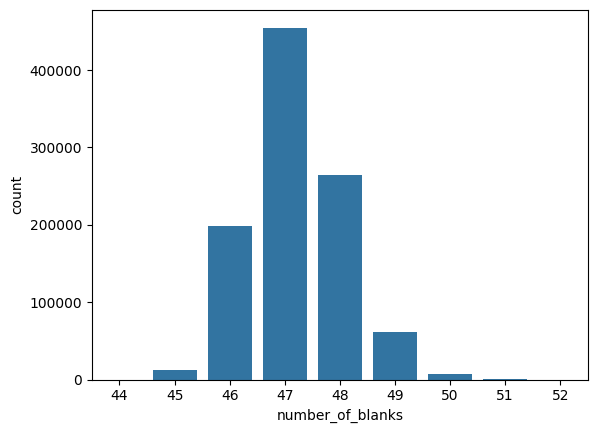

In [22]:
import seaborn as sns
sns.countplot(x=data['number_of_blanks'])

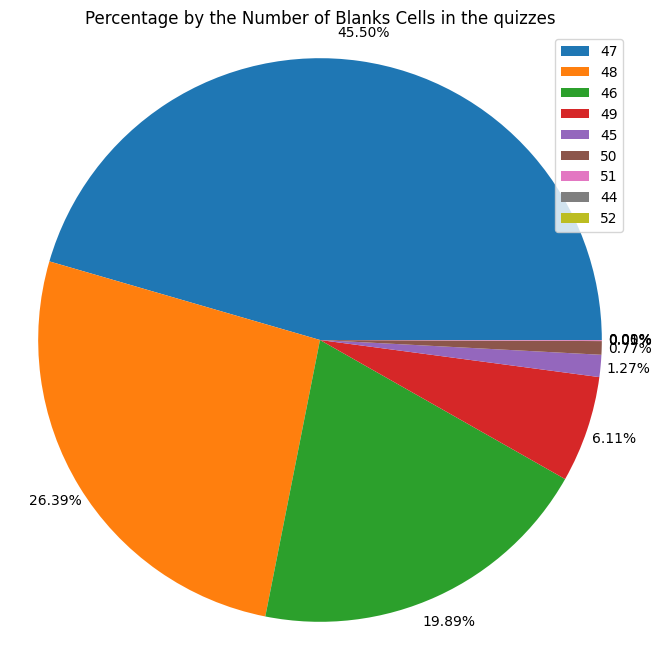

In [23]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(data['number_of_blanks'].value_counts(), autopct='%1.2f%%', pctdistance=1.1)
ax1.legend(data['number_of_blanks'].value_counts().index)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Percentage by the Number of Blanks Cells in the quizzes")
plt.savefig("pie_chart_blanks.png")


In [24]:
from stable_baselines3.common.callbacks import CheckpointCallback, BaseCallback

class RewardTrackerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.state_log = []  # Store the states for plotting the distribution

    def _on_step(self) -> bool:
        # Capture the rewards at each step
        if 'dones' in self.locals and any(self.locals['dones']):
            self.episode_rewards.append(sum(self.locals['rewards']))
            # Capture the state (observation) from the environment directly
            # This assumes `self.model.env` holds the environment
            obs = self.model.env.reset()  # Capture the new state after each episode ends
            self.state_log.append(obs)
        return True





Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.75     |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4379     |
|    time_elapsed     | 0        |
|    total_timesteps  | 11       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 6.78     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3762     |
|    time_elapsed     | 0        |
|    total_timesteps  | 17       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 5.19     |
|    exploration_rate | 0.977    |
| t

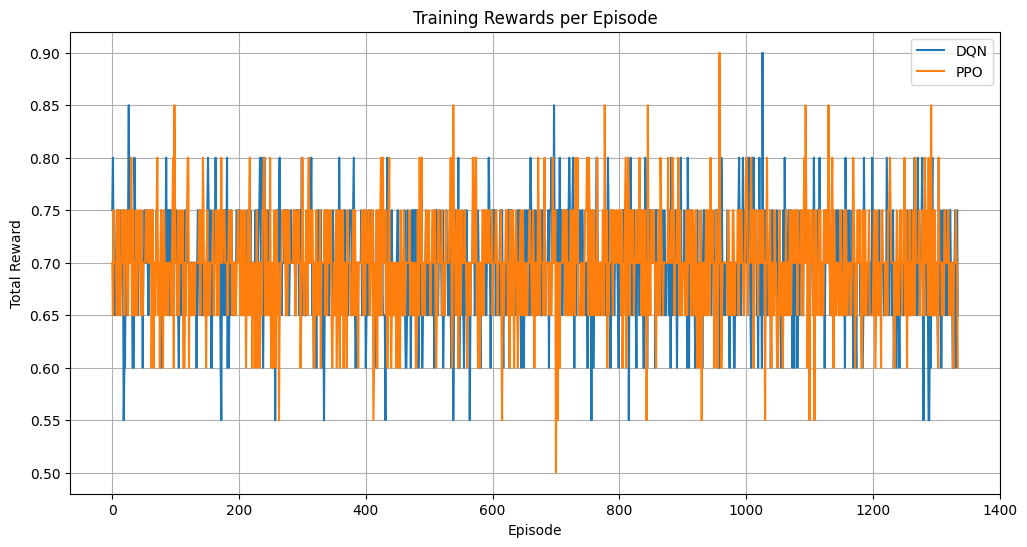

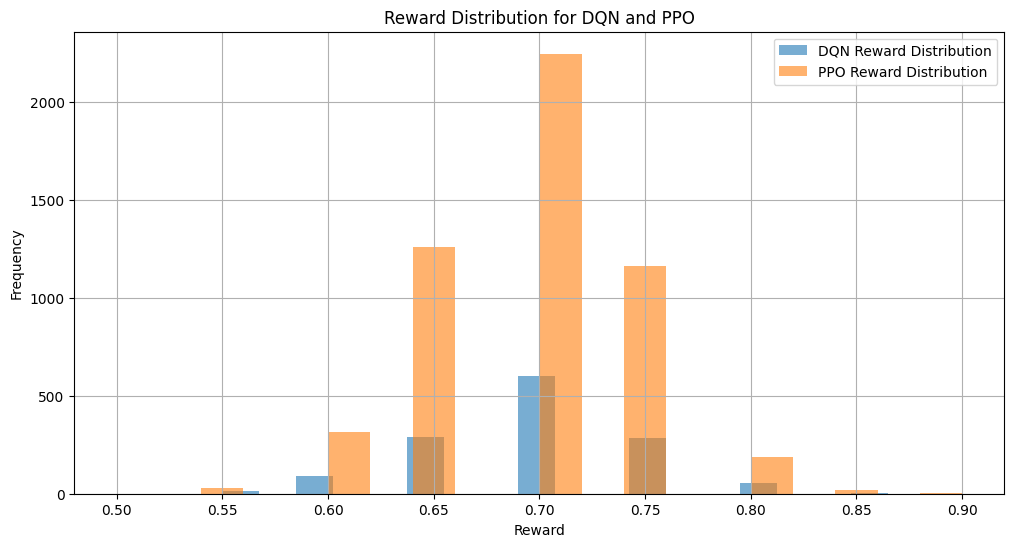

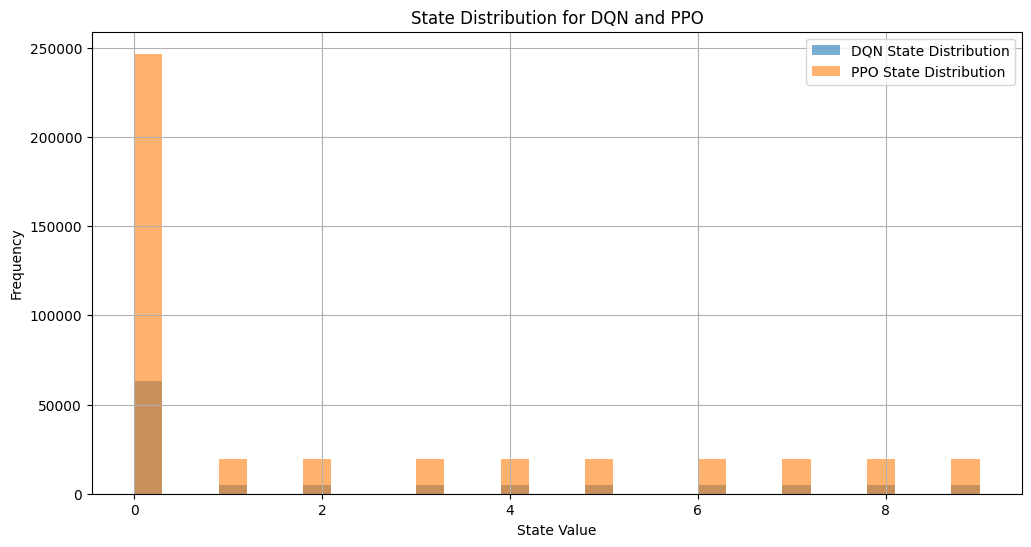


Final Results:
DQN - Avg Reward: 41.33, Success Rate: 100.00%
PPO - Avg Reward: 2.80, Success Rate: 100.00%
✅ DQN performed better than PPO in terms of success rate.


In [25]:
import matplotlib.pyplot as plt

# --- Custom Sudoku Environment ---
class SudokuEnv(gym.Env):
    def __init__(self):
        super(SudokuEnv, self).__init__()
        self.action_space = spaces.Discrete(81 * 9)
        self.observation_space = spaces.Box(0, 9, shape=(81,), dtype=np.int32)
        self.current_puzzle = None
        self.solution = None
        self.action_log = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        index = np.random.randint(len(data))
        puzzle = data.iloc[index]['quizzes']
        solution = data.iloc[index]['solutions']
        self.current_puzzle = np.array([int(x) for x in puzzle], dtype=np.int32)
        self.solution = np.array([int(x) for x in solution], dtype=np.int32)
        self.action_log = []
        return self.current_puzzle.copy(), {}

    def step(self, action):
        self.action_log.append(action)
        cell = action // 9
        value = (action % 9) + 1

        reward = 1
        terminated = False

        if self.current_puzzle[cell] == 0:
            if self.solution[cell] == value:
                self.current_puzzle[cell] = value
                reward += 10

                row = cell // 9
                col = cell % 9

                if np.array_equal(self.current_puzzle[row * 9:(row + 1) * 9], self.solution[row * 9:(row + 1) * 9]):
                    reward += 5

                if np.array_equal(self.current_puzzle[col::9], self.solution[col::9]):
                    reward += 5

                box_row, box_col = row // 3, col // 3
                indices = []
                for i in range(3):
                    for j in range(3):
                        indices.append((box_row * 3 + i) * 9 + (box_col * 3 + j))
                if np.array_equal(self.current_puzzle[indices], self.solution[indices]):
                    reward += 5

                terminated = np.array_equal(self.current_puzzle, self.solution)
            else:
                reward -= 2
                terminated = True
        else:
            reward -= 1

        reward += np.sum(self.current_puzzle == self.solution) * 0.05
        return self.current_puzzle.copy(), reward, terminated, False, {}

# --- Initialize environment and check ---
env = Monitor(SudokuEnv())  # Removed Monitor CSV logging
check_env(env)

# --- Callbacks ---
reward_callback_dqn = RewardTrackerCallback()
reward_callback_ppo = RewardTrackerCallback()

checkpoint_callback_dqn = CheckpointCallback(save_freq=1000, save_path='../models/dqn/')
checkpoint_callback_ppo = CheckpointCallback(save_freq=1000, save_path='../models/ppo/')

# --- Train DQN ---
model_dqn = DQN(
    'MlpPolicy',
    env,
    verbose=1,
    learning_rate=0.0001,
    batch_size=64,
    buffer_size=100000,
    exploration_fraction=0.1,
    gradient_steps=1,
    target_update_interval=1000,
    policy_kwargs={"net_arch": [128, 128]}
)
model_dqn.learn(total_timesteps=10000, callback=[checkpoint_callback_dqn, reward_callback_dqn])

# --- Train PPO ---
model_ppo = PPO(
    'MlpPolicy',
    env,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    ent_coef=0.01,
    clip_range=0.2,
    policy_kwargs={"net_arch": [128, 128]}
)
model_ppo.learn(total_timesteps=10000, callback=[checkpoint_callback_ppo, reward_callback_ppo])

# --- Plot Rewards vs. Episode ---
min_len = min(len(reward_callback_dqn.episode_rewards), len(reward_callback_ppo.episode_rewards))
plt.figure(figsize=(12, 6))
plt.plot(reward_callback_dqn.episode_rewards[:min_len], label="DQN")
plt.plot(reward_callback_ppo.episode_rewards[:min_len], label="PPO")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards per Episode")
plt.legend()
plt.grid(True)
plt.show()

# --- Reward Distribution Visualization ---
def plot_reward_distribution(reward_dqn, reward_ppo):
    plt.figure(figsize=(12, 6))
    plt.hist(reward_dqn, bins=20, alpha=0.6, label='DQN Reward Distribution')
    plt.hist(reward_ppo, bins=20, alpha=0.6, label='PPO Reward Distribution')
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title("Reward Distribution for DQN and PPO")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- State Distribution Visualization ---
def plot_state_distribution(state_log_dqn, state_log_ppo):
    dqn_states = np.array(state_log_dqn)
    ppo_states = np.array(state_log_ppo)
    plt.figure(figsize=(12, 6))
    plt.hist(dqn_states.flatten(), bins=30, alpha=0.6, label='DQN State Distribution')
    plt.hist(ppo_states.flatten(), bins=30, alpha=0.6, label='PPO State Distribution')
    plt.xlabel("State Value")
    plt.ylabel("Frequency")
    plt.title("State Distribution for DQN and PPO")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Evaluate DQN vs PPO ---
def evaluate_model(model, env, num_episodes=100):
    rewards = []
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, truncated, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
        if total_reward > 0:  # Check if the model solved the puzzle
            successes += 1
    return np.mean(rewards), successes / num_episodes

reward_dqn, success_rate_dqn = evaluate_model(model_dqn, env)
reward_ppo, success_rate_ppo = evaluate_model(model_ppo, env)

# --- Plot Reward Distribution ---
plot_reward_distribution(reward_callback_dqn.episode_rewards, reward_callback_ppo.episode_rewards)

# --- Plot State Distribution ---
plot_state_distribution(reward_callback_dqn.state_log, reward_callback_ppo.state_log)

# --- Print Summary ---
def print_final_results():
    print("\nFinal Results:")
    print(f"DQN - Avg Reward: {reward_dqn:.2f}, Success Rate: {success_rate_dqn * 100:.2f}%")
    print(f"PPO - Avg Reward: {reward_ppo:.2f}, Success Rate: {success_rate_ppo * 100:.2f}%")

    if reward_dqn > reward_ppo:
        print("✅ DQN performed better than PPO in terms of success rate.")
    elif reward_ppo > reward_dqn:
        print("✅ PPO performed better than DQN in terms of success rate.")
    else:
        print("⚖️ Both DQN and PPO had the same success rate.")

print_final_results()


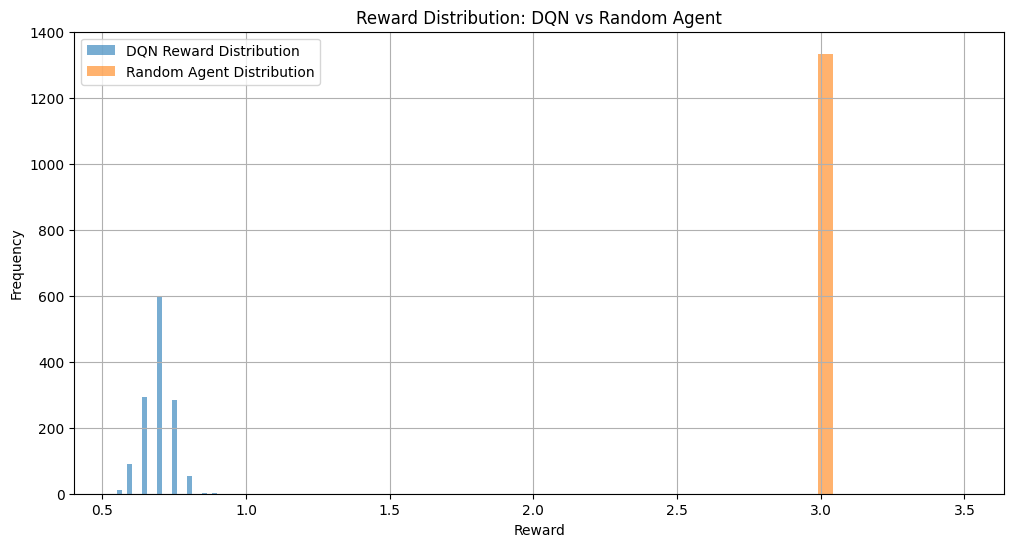


Final Results:
Random - Avg Reward: 2.99, Success Rate: 100.00%
DQN    - Avg Reward: 41.33, Success Rate: 100.00%
✅ DQN performed better than the Random Agent.


In [26]:
def evaluate_random_agent(env, num_episodes=100):
    rewards = []
    successes = 0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = env.action_space.sample() 
            obs, reward, done, truncated, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
        if total_reward > 0:  
            successes += 1
    return np.mean(rewards), successes / num_episodes

reward_random, success_rate_random = evaluate_random_agent(env)

def plot_reward_distribution_dqn_vs_random(reward_dqn, reward_random_value, length):
    random_rewards = [reward_random_value] * length
    plt.figure(figsize=(12, 6))
    plt.hist(reward_dqn, bins=20, alpha=0.6, label='DQN Reward Distribution')
    plt.hist(random_rewards, bins=20, alpha=0.6, label='Random Agent Distribution')
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title("Reward Distribution: DQN vs Random Agent")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_reward_distribution_dqn_vs_random(
    reward_callback_dqn.episode_rewards,
    reward_random,
    len(reward_callback_dqn.episode_rewards)
)

def print_final_results():
    print("\nFinal Results:")
    print(f"Random - Avg Reward: {reward_random:.2f}, Success Rate: {success_rate_random * 100:.2f}%")
    print(f"DQN    - Avg Reward: {reward_dqn:.2f}, Success Rate: {success_rate_dqn * 100:.2f}%")

    if reward_dqn > reward_random:
        print("✅ DQN performed better than the Random Agent.")
    elif reward_random > reward_dqn:
        print("⚠️ Random Agent performed better than DQN.")
    else:
        print("⚖️ Both DQN and Random Agent had the same performance.")

print_final_results()

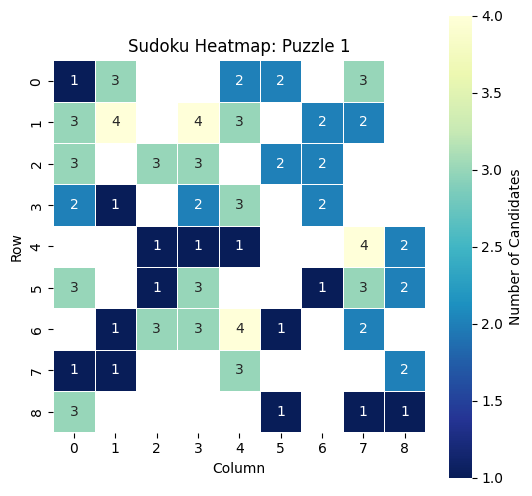

In [43]:
# === Functions ===

def str_to_grid(sudoku_str):
    return [[int(sudoku_str[i * 9 + j]) for j in range(9)] for i in range(9)]

def get_candidates(grid, row, col):
    if grid[row][col] != 0:
        return []

    row_vals = set(grid[row])
    col_vals = set(grid[i][col] for i in range(9))
    block_vals = set(
        grid[r][c]
        for r in range((row // 3) * 3, (row // 3) * 3 + 3)
        for c in range((col // 3) * 3, (col // 3) * 3 + 3)
    )

    used = row_vals | col_vals | block_vals
    return [n for n in range(1, 10) if n not in used]

def sudoku_heatmap(puzzle_str):
    grid = str_to_grid(puzzle_str)
    heatmap = np.full((9, 9), np.nan)

    for i in range(9):
        for j in range(9):
            if grid[i][j] == 0:
                candidates = get_candidates(grid, i, j)
                heatmap[i, j] = len(candidates)

    return heatmap

def plot_heatmap(heatmap_matrix, title="Sudoku Candidate Heatmap"):
    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_matrix, cmap="YlGnBu_r", annot=True, square=True, linewidths=0.5,
                cbar_kws={'label': 'Number of Candidates'})
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


puzzle_str = data.loc[0, 'quizzes']  # assuming the column name is "quizzes"
heatmap = sudoku_heatmap(puzzle_str)
plot_heatmap(heatmap, title="Sudoku Heatmap: Puzzle 1")

In [49]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to print the Sudoku board in the console
def print_board(board):
    os.system('cls' if os.name == 'nt' else 'clear')  # Clear the console
    print("Solving Sudoku Step-by-Step:\n")
    for i in range(9):
        row = board[i * 9:(i + 1) * 9]
        print(" ".join(str(num) if num != 0 else "." for num in row))
    print("\n")
    time.sleep(0.3)  # Delay between steps

# Function to plot a heatmap of the Sudoku grid
def plot_sudoku_heatmap(board, title="Sudoku Grid Heatmap"):
    grid = np.array(board).reshape((9, 9))
    plt.figure(figsize=(7, 6))
    sns.heatmap(grid, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=0.5, linecolor='black')
    plt.title(title)
    plt.xticks(np.arange(9) + 0.5, labels=[str(i+1) for i in range(9)])
    plt.yticks(np.arange(9) + 0.5, labels=[str(i+1) for i in range(9)], rotation=1)
    plt.show()

# Function to solve Sudoku step-by-step, displaying board and heatmap
def solve_sudoku_step_by_step(model, env):
    obs, _ = env.reset()
    done = False

    raw_env = env.env
    current_board = raw_env.current_puzzle.copy()

    # Show the initial puzzle heatmap
    plot_sudoku_heatmap(current_board, title="Initial Sudoku Puzzle")
    time.sleep(1)  # Delay before starting the solution

    while not done:
        action, _ = model.predict(obs)
        cell = action // 9
        value = (action % 9) + 1

        if current_board[cell] != 0:
            continue

        obs, _, done, _, _ = env.step(action)

        # Update the board and print the updated state
        current_board[cell] = value
        print_board(current_board)
        
        # Plot the heatmap after each step
        plot_sudoku_heatmap(current_board, title="Step-by-Step Solving")

    # Plot the solution heatmap
    solution = raw_env.solution
    print("✅ Final Solved Sudoku:")
    print_board(solution)
    plot_sudoku_heatmap(solution, title="Solved Sudoku Puzzle")


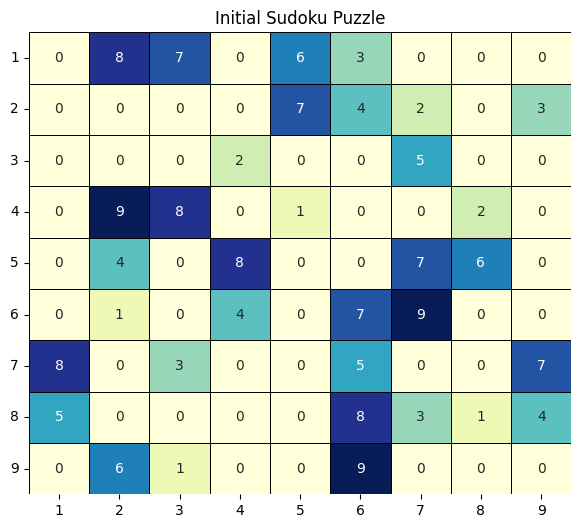

Solving Sudoku Step-by-Step:

. 8 7 . 6 3 . . .
. . . . 7 4 2 . 3
. . . 2 . . 5 . .
. 9 8 . 1 . . 2 .
. 4 . 8 . . 7 6 .
. 1 . 4 . 7 9 . .
8 . 3 . 4 5 . . 7
5 . . . . 8 3 1 4
. 6 1 . . 9 . . .




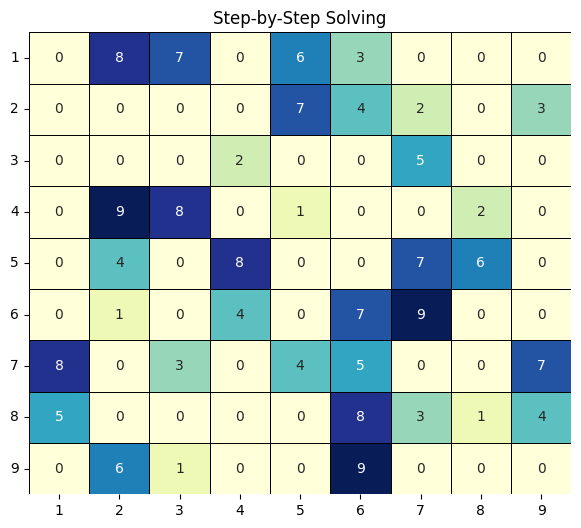

Solving Sudoku Step-by-Step:

. 8 7 . 6 3 . . .
. . . . 7 4 2 . 3
. . . 2 . . 5 . .
. 9 8 3 1 . . 2 .
. 4 . 8 . . 7 6 .
. 1 . 4 . 7 9 . .
8 . 3 . 4 5 . . 7
5 . . . . 8 3 1 4
. 6 1 . . 9 . . .




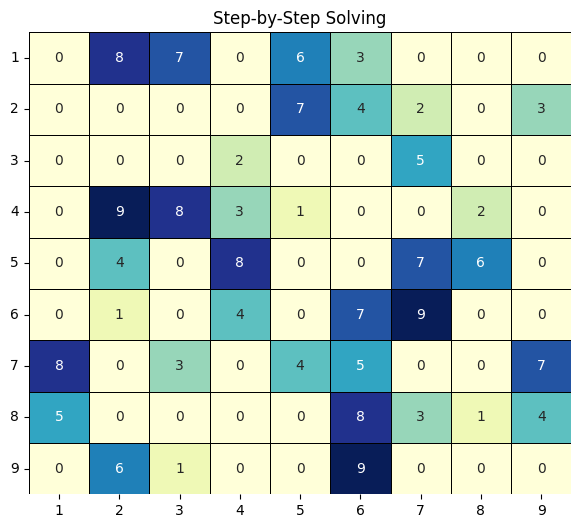

Solving Sudoku Step-by-Step:

. 8 7 . 6 3 . . .
. . . . 7 4 2 . 3
. . . 2 . . 5 . .
. 9 8 3 1 . . 2 .
. 4 . 8 . . 7 6 .
. 1 . 4 . 7 9 . .
8 . 3 . 4 5 . . 7
5 . . . . 8 3 1 4
. 6 1 . . 9 . 2 .




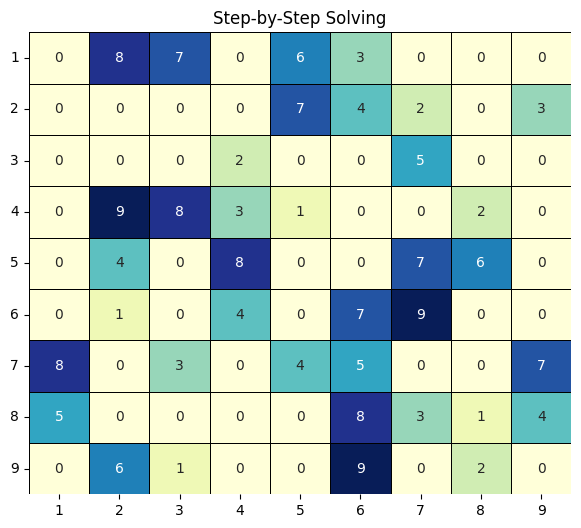

✅ Final Solved Sudoku:
Solving Sudoku Step-by-Step:

2 8 7 5 6 3 1 4 9
1 5 6 9 7 4 2 8 3
9 3 4 2 8 1 5 7 6
7 9 8 3 1 6 4 2 5
3 4 5 8 9 2 7 6 1
6 1 2 4 5 7 9 3 8
8 2 3 1 4 5 6 9 7
5 7 9 6 2 8 3 1 4
4 6 1 7 3 9 8 5 2




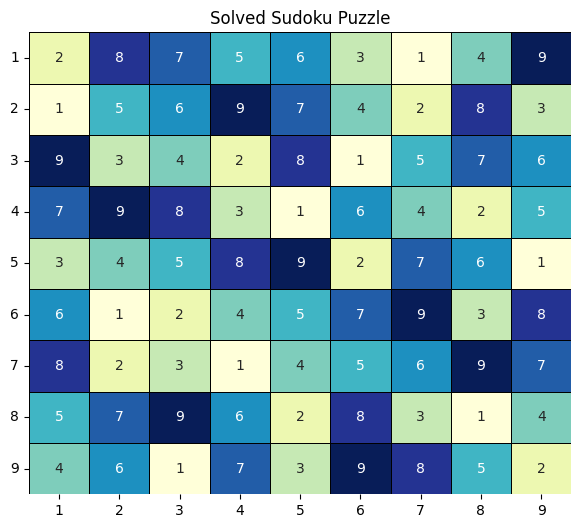

In [50]:
solve_sudoku_step_by_step(model_dqn, env)
